# CSE547 Final Project - Clustering
## K-Means





### Spark Setup

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=88238b70eec09103aa4243273ba279fcb239dd67904ed26a6d8f7b7119aba58b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

### Import libraries




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col

import pickle
from statistics import median

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import col

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
conf = SparkConf()\
    .set("spark.ui.port", "4050")\
    .set("spark.executor.memory", "8g")

sc = SparkContext.getOrCreate(conf=conf)
spark = SparkSession.builder.config(conf=sc.getConf()).getOrCreate()

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2024-05-31 01:05:29--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 54.237.133.81, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  39.1MB/s    in 0.3s    

2024-05-31 01:05:29 (39.1 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.10/json/__init__.py", line 293, in load
    return loads(fp.read(),
  File "/usr/lib/python3.10/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.10/json/decoder.py", line 337, in decode
    obj,

### Data Loading and Preprocessing

In [ ]:
# Load Glioma data:
df_load_glioma = spark.read.csv('pyradiomics_results_cleaned.csv', header=True, inferSchema=True)
df_glioma = df_load_glioma.drop('ImageID')  # Remove the ImageID so it is not included as a feature

feature_columns_glioma = df_glioma.columns

# Assemble the features into a single vector column
assembler_glioma = VectorAssembler(inputCols=feature_columns_glioma, outputCol="features")
df_assembled_glioma = assembler_glioma.transform(df_glioma)

scaler_glioma = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model_glioma = scaler_glioma.fit(df_assembled_glioma)
df_scaled_glioma = scaler_model_glioma.transform(df_assembled_glioma)

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id, col, collect_list

# Load Glioma data:
df_load_glioma = spark.read.csv('pyradiomics_results_cleaned.csv', header=True, inferSchema=True)
df_glioma = df_load_glioma.drop('ImageID')  # This is for feature processing
df_glioma_with_id = df_load_glioma.withColumn("row_id", monotonically_increasing_id())  # Keep ImageID for joining later

feature_columns_glioma = [col for col in df_glioma.columns if col != 'ImageID']

# Assemble the features into a single vector column
assembler_glioma = VectorAssembler(inputCols=feature_columns_glioma, outputCol="features")
df_assembled_glioma = assembler_glioma.transform(df_glioma)

# Scale the features
scaler_glioma = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
df_scaled_glioma = scaler_glioma.fit(df_assembled_glioma).transform(df_assembled_glioma)


In [ ]:
df_load = spark.read.csv('pyradiomics_GoAT_results_cleaned.csv', header=True, inferSchema=True)
df = df_load.drop('ImageID')  # Remove the ImageID so it is not included as a feature

In [ ]:
from pyspark.sql.functions import col, regexp_replace
from pyspark.sql.types import DoubleType

# List of columns that need to be converted
columns_to_convert = [
    'original_shape_Elongation',
    'original_shape_Flatness',
    'original_shape_LeastAxisLength',
    'original_shape_MajorAxisLength',
    'original_shape_MinorAxisLength'
]

# Apply conversion
for column in columns_to_convert:
    df = df.withColumn(
        column,
        regexp_replace(col(column), "E", "e").cast(DoubleType())
    )

# Assuming df is your DataFrame loaded from CSV
for column in df.columns:
  df = df.na.fill({column: df.agg(mean(df[column])).first()[0]})
    # df = df.na.fill({column: 0})  # Replace nan with 0

In [ ]:
feature_columns = df.columns

# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(df)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

In [ ]:
import os
import pickle
import pandas as pd

# Create directories to save results
os.makedirs('results/kmeans/', exist_ok=True)

Silhouette with squared euclidean distance for k = 2 (Regular): 0.2845721010941857
Silhouette with squared euclidean distance for k = 2 (Glioma): 0.27989085894206456
Regular Samples:
+----------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

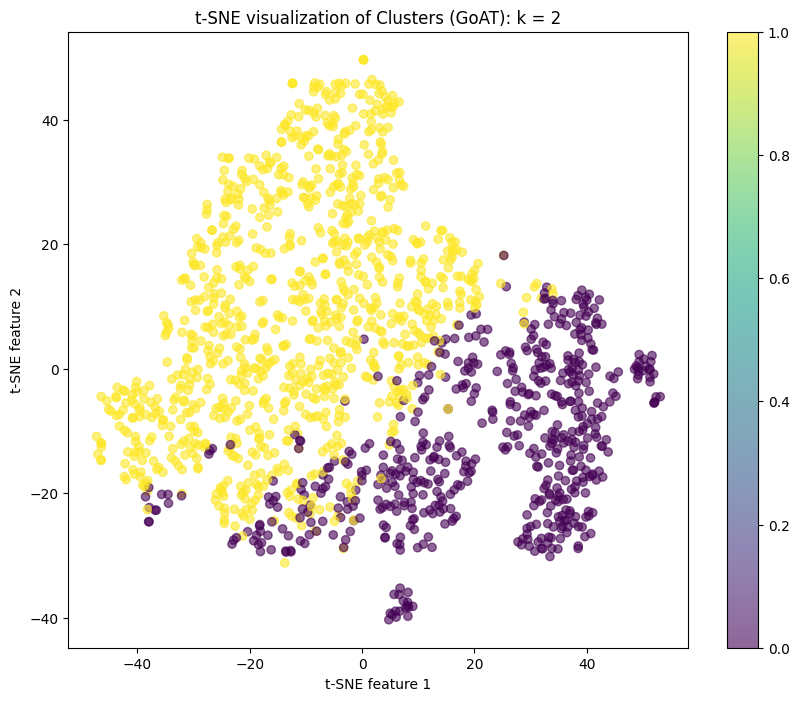

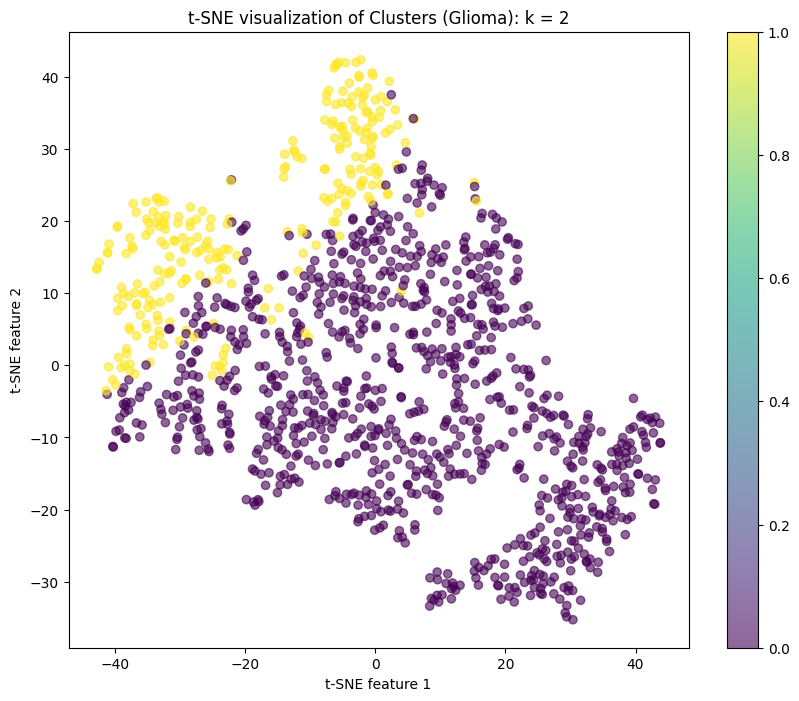

Silhouette with squared euclidean distance for k = 3 (Regular): 0.36745939097048513
Silhouette with squared euclidean distance for k = 3 (Glioma): 0.31621511599217544
Regular Samples:
+----------+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

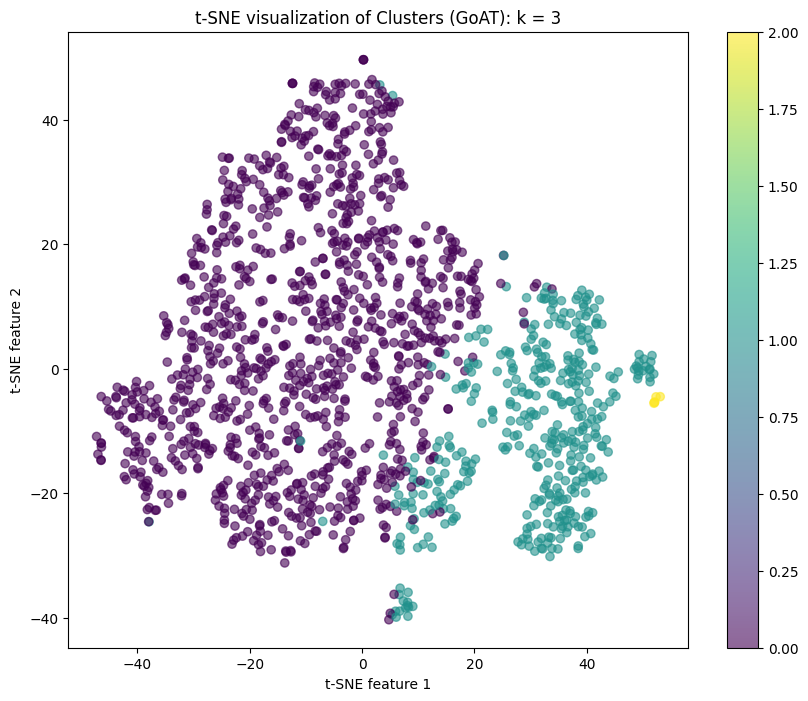

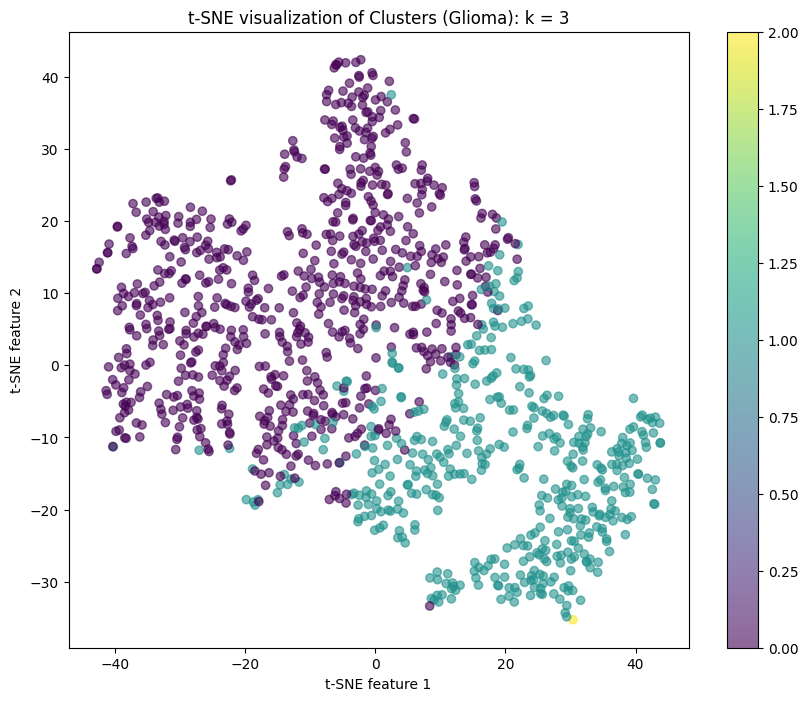

Silhouette with squared euclidean distance for k = 4 (Regular): 0.2542448493008198
Silhouette with squared euclidean distance for k = 4 (Glioma): 0.7134939399321707
Regular Samples:
+----------+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

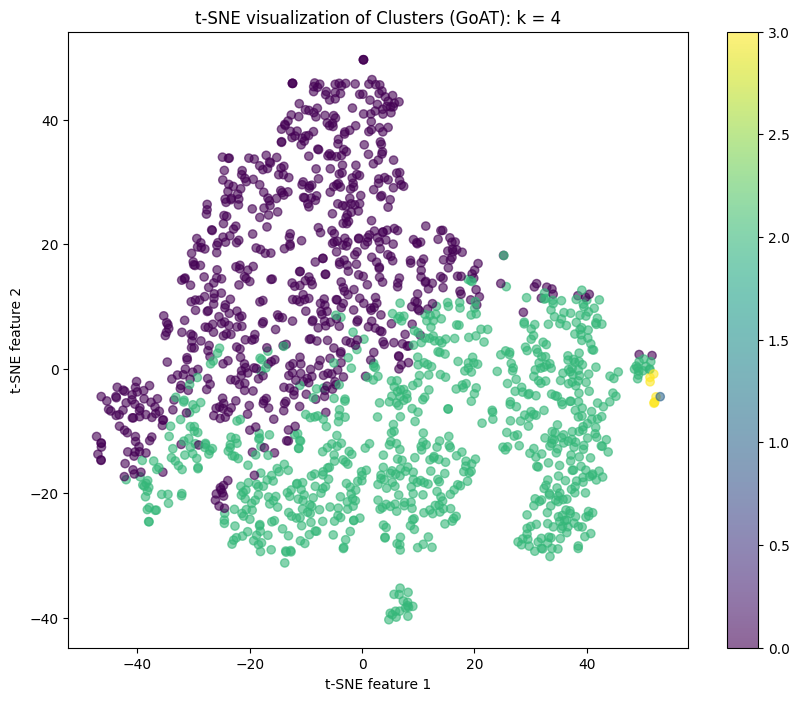

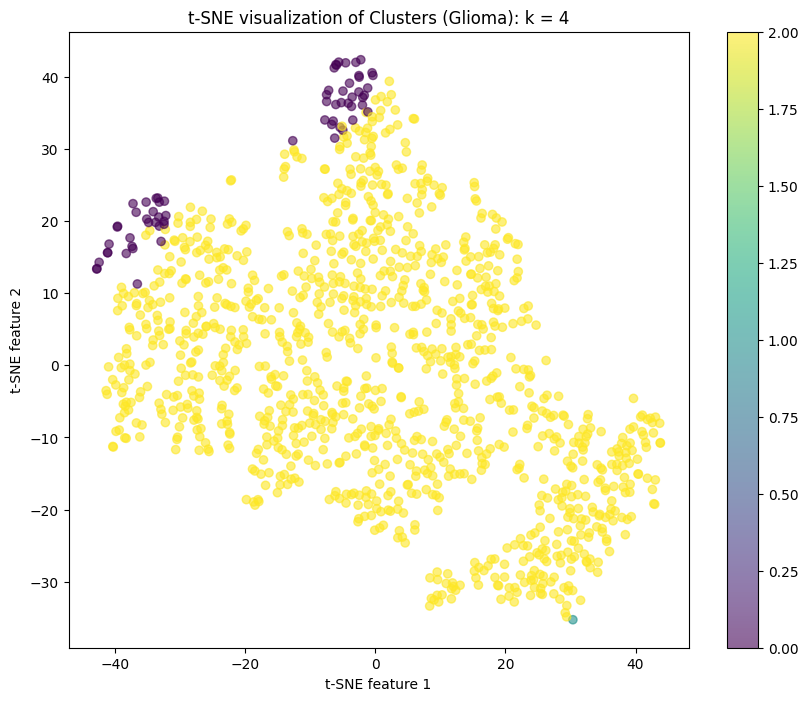

Silhouette with squared euclidean distance for k = 5 (Regular): 0.2606113124653529
Silhouette with squared euclidean distance for k = 5 (Glioma): 0.7470468717395158
Regular Samples:
+----------+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

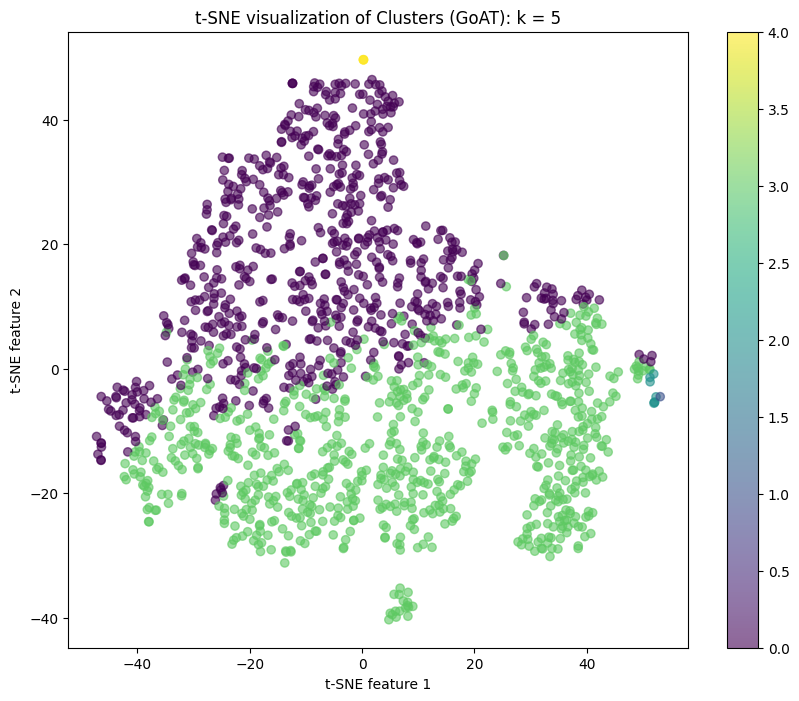

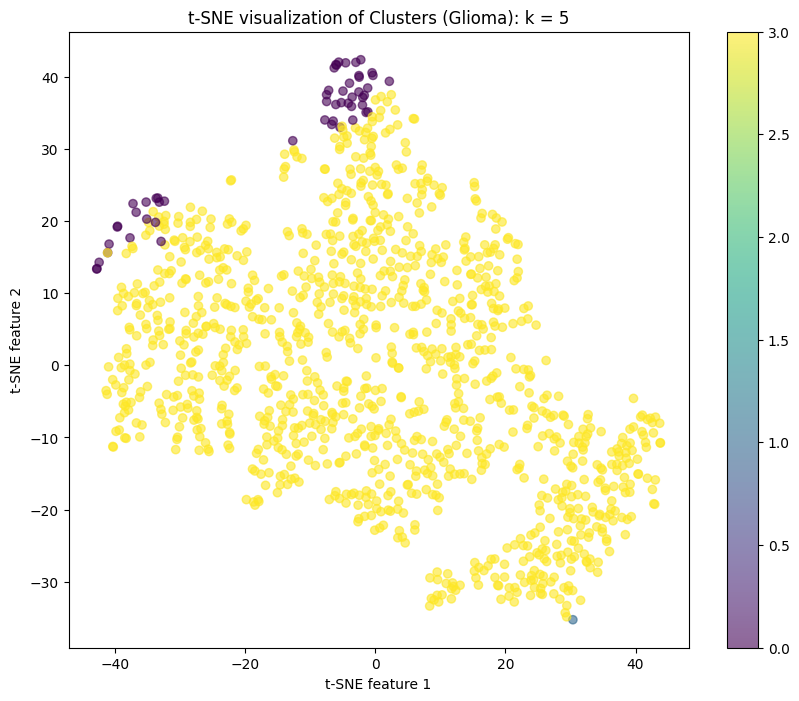

Silhouette with squared euclidean distance for k = 6 (Regular): 0.2879013112142089
Silhouette with squared euclidean distance for k = 6 (Glioma): 0.41153257119639947
Regular Samples:
+----------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

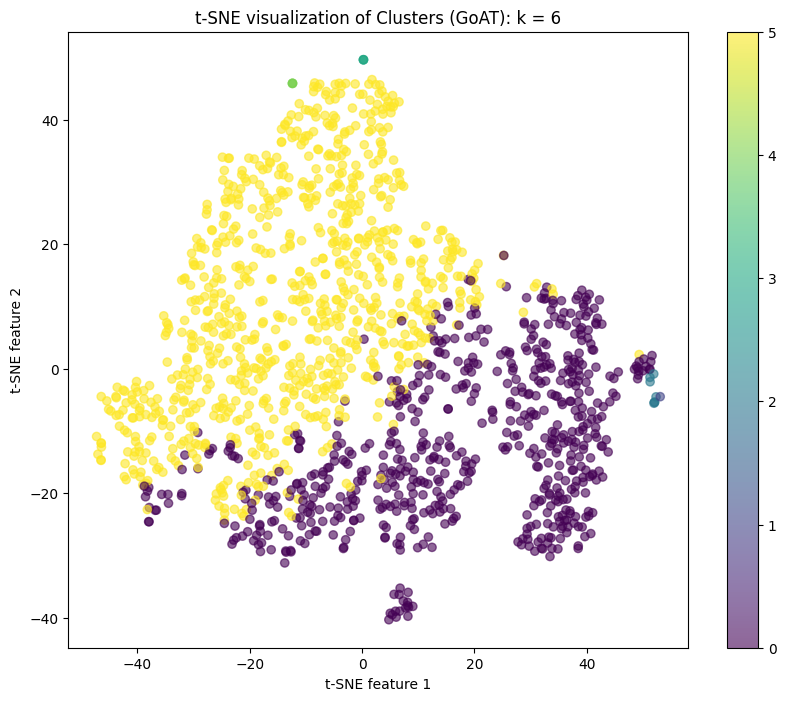

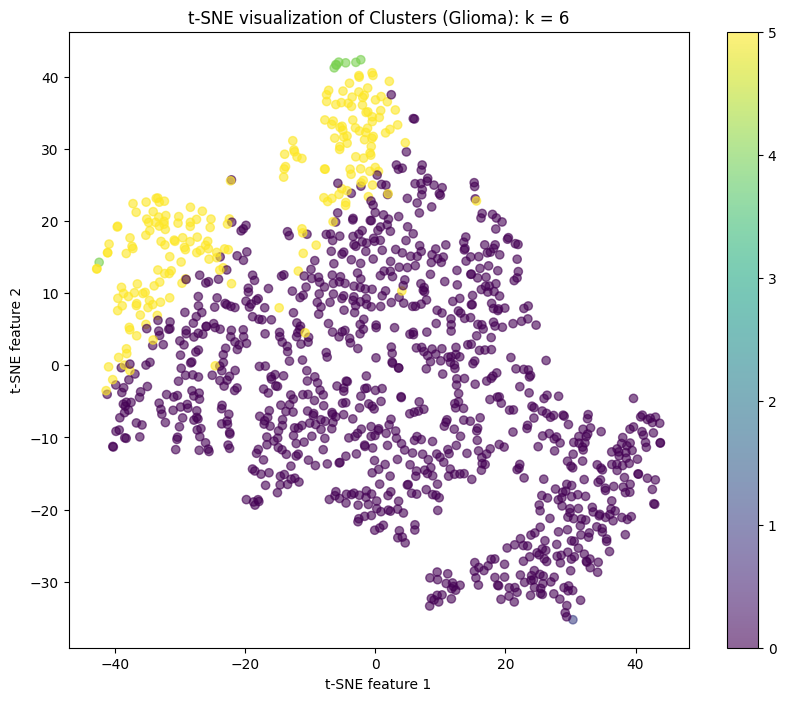

Silhouette with squared euclidean distance for k = 7 (Regular): 0.32105550856741816
Silhouette with squared euclidean distance for k = 7 (Glioma): 0.4360736073119537
Regular Samples:
+----------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

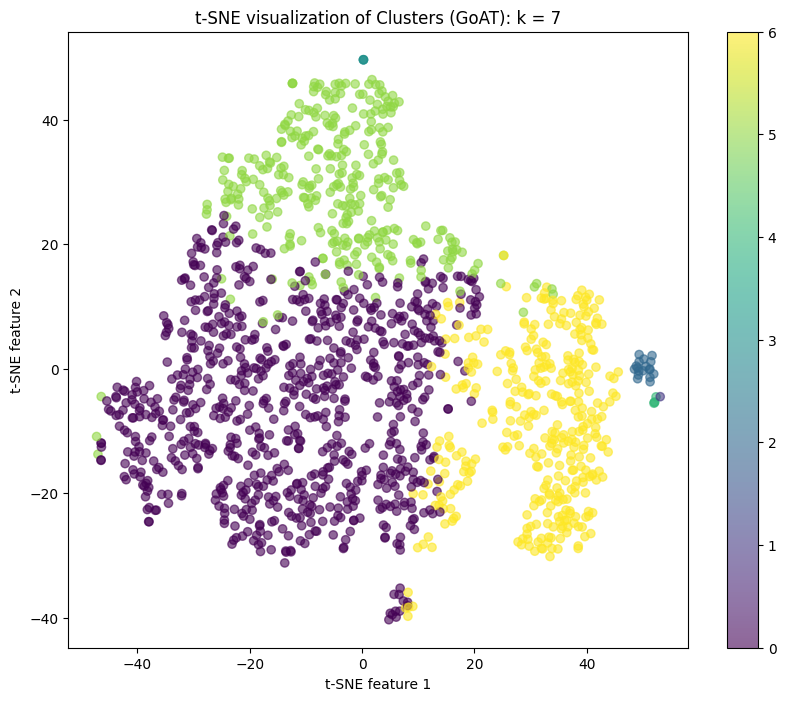

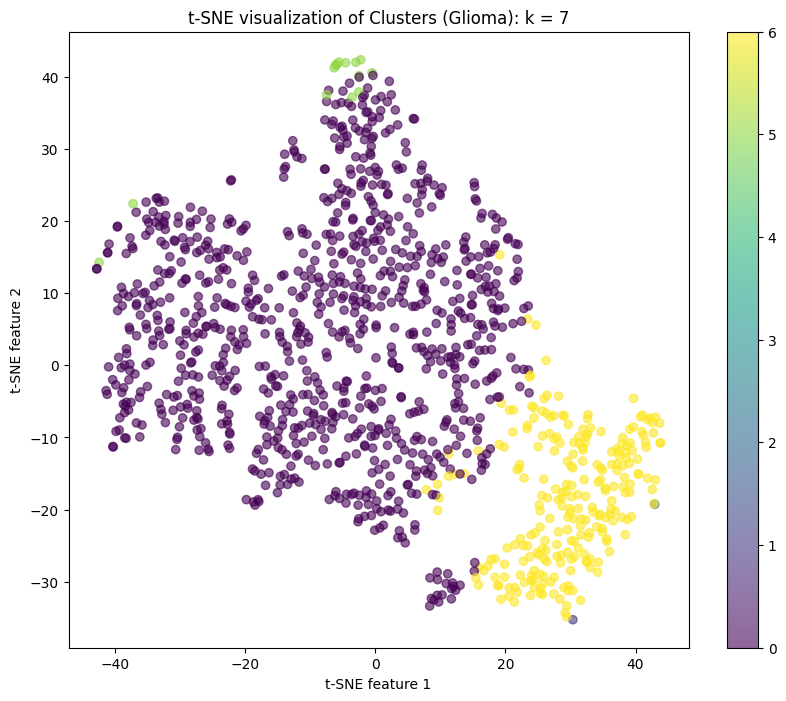

Silhouette with squared euclidean distance for k = 8 (Regular): 0.30507130961305495
Silhouette with squared euclidean distance for k = 8 (Glioma): 0.48347708665639033
Regular Samples:
+----------+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

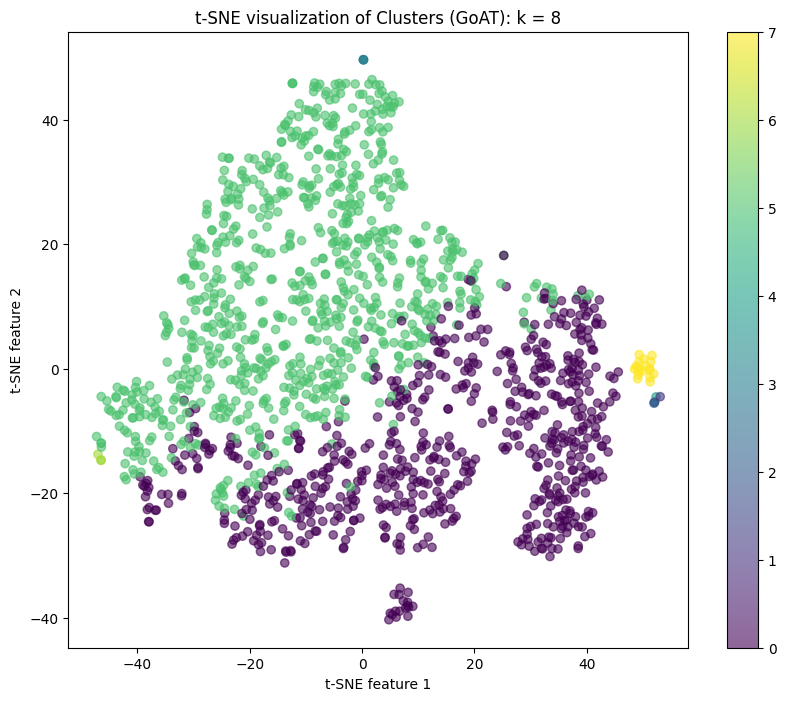

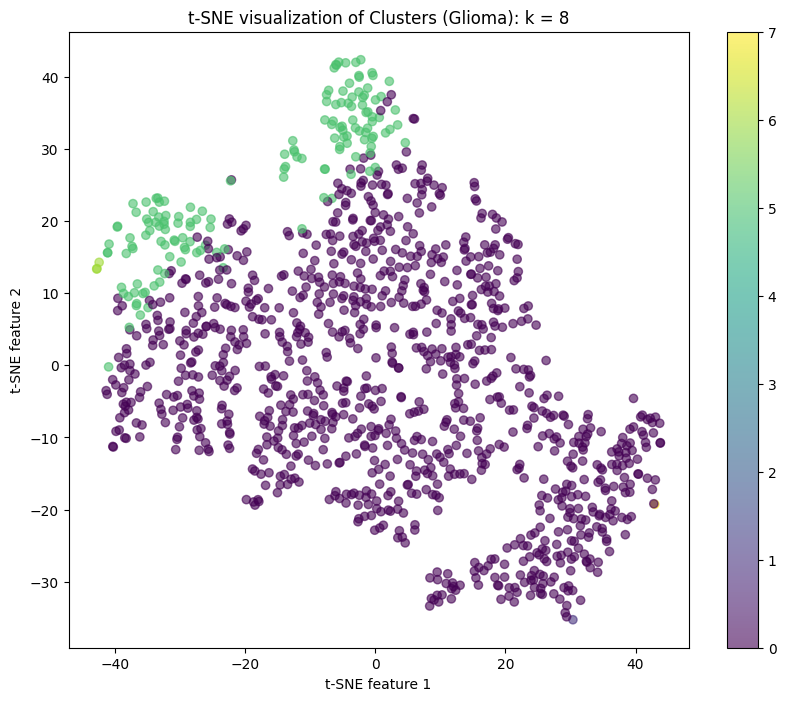

Silhouette with squared euclidean distance for k = 9 (Regular): 0.2987064243252014
Silhouette with squared euclidean distance for k = 9 (Glioma): 0.32688638905506084
Regular Samples:
+----------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

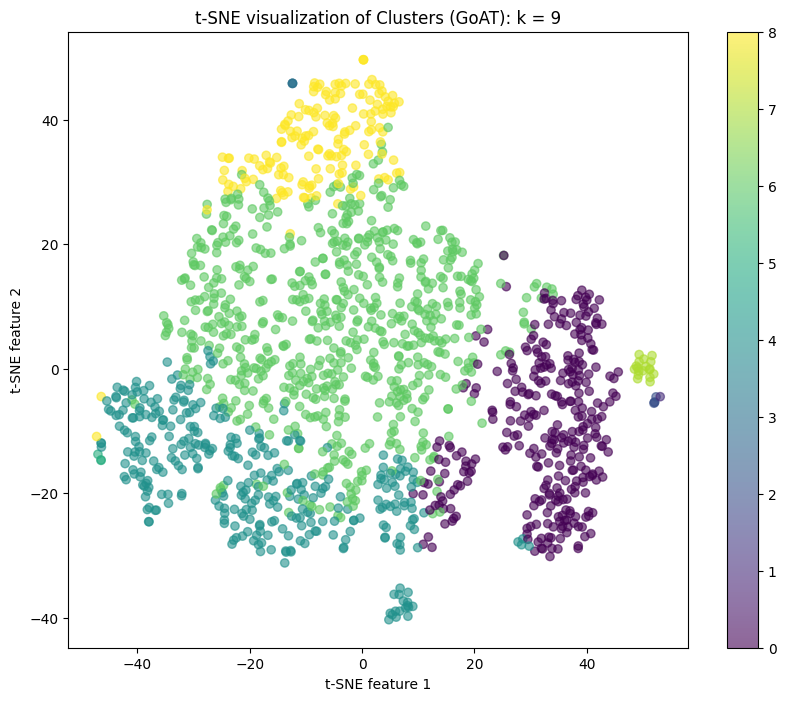

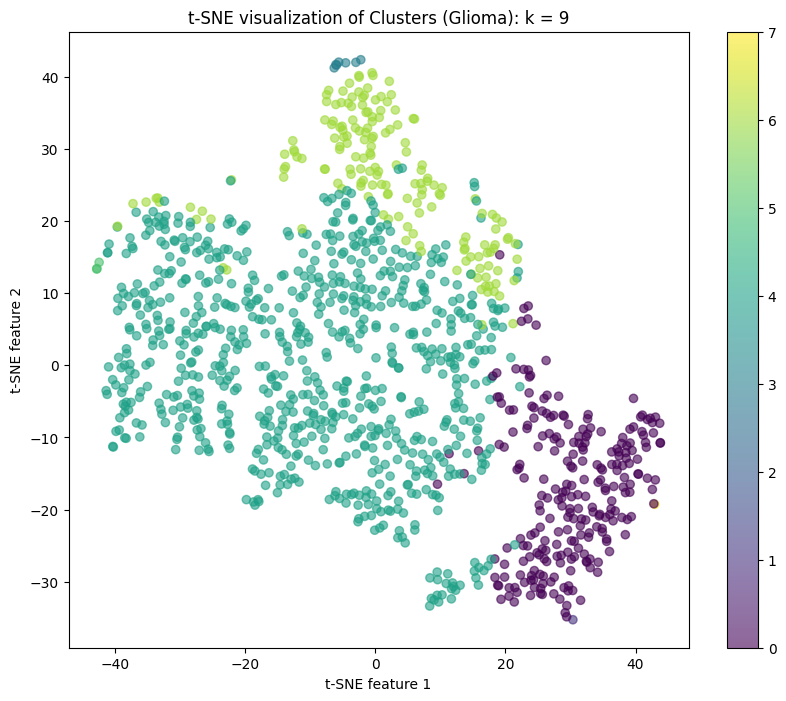

Silhouette with squared euclidean distance for k = 10 (Regular): 0.35863409932268225
Silhouette with squared euclidean distance for k = 10 (Glioma): 0.32255164153439303
Regular Samples:
+----------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

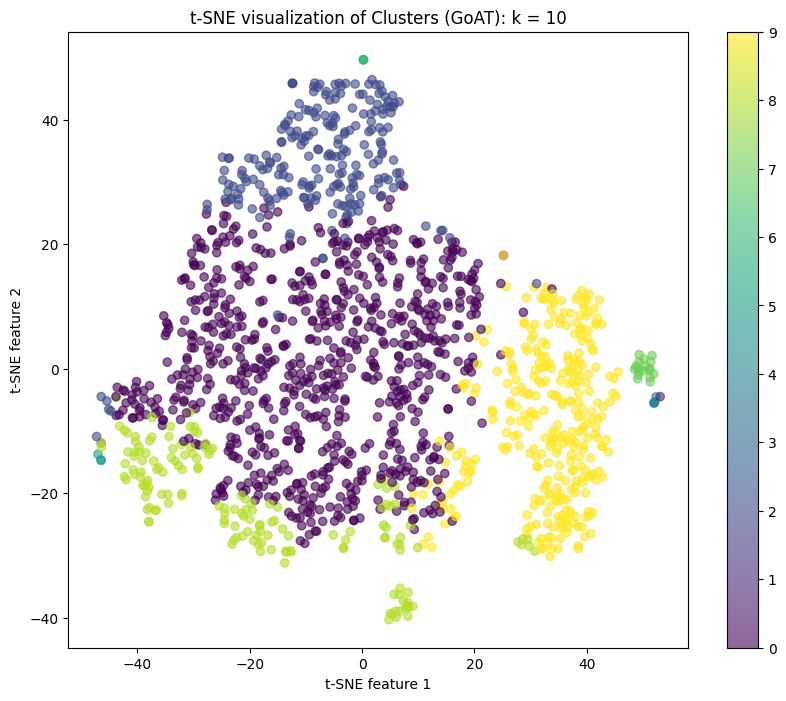

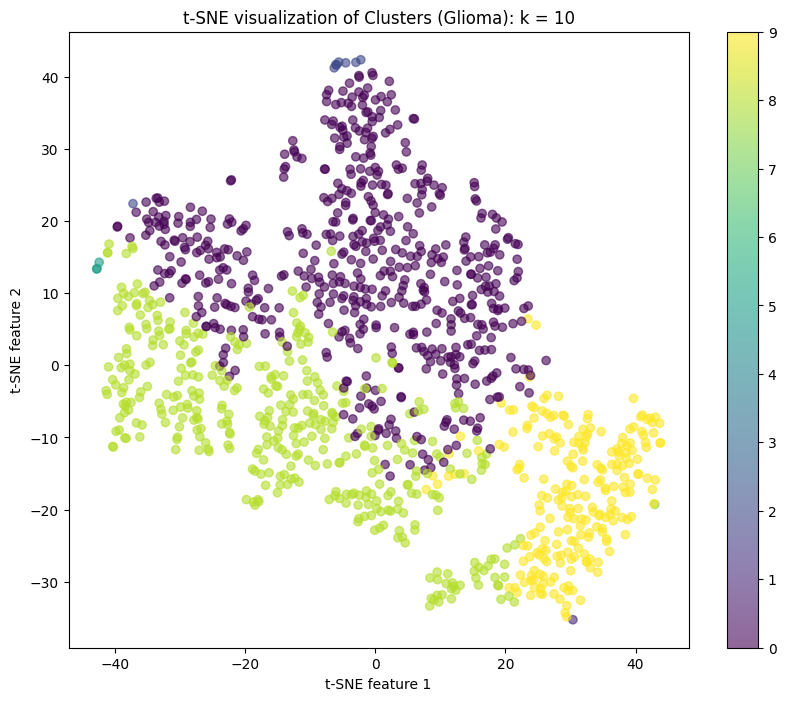

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id, col, collect_list, udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# User defined function (UDF) for sorting ImageIDs
sort_udf = udf(lambda x: sorted(x), ArrayType(StringType()))

k_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
df_load_with_id = df_load.withColumn("row_id", monotonically_increasing_id())  # Assign row_id once outside the loop
df_glioma_with_id = df_load_glioma.withColumn("row_id", monotonically_increasing_id())  # Similarly for glioma dataset
features = df_scaled.select("scaledFeatures").rdd.map(lambda row: row.scaledFeatures.toArray()).collect()
features_glioma = df_scaled_glioma.select("scaledFeatures").rdd.map(lambda row: row.scaledFeatures.toArray()).collect()


for k in k_list:
    kmeans = KMeans(featuresCol='scaledFeatures', k=k)
    model = kmeans.fit(df_scaled)

    # Regular dataset predictions and processing
    predictions = model.transform(df_scaled)
    predictions_with_id = predictions.withColumn("row_id", monotonically_increasing_id())
    predictions_with_ids = df_load_with_id.join(predictions_with_id, "row_id").drop("row_id")

    evaluator = ClusteringEvaluator(featuresCol='scaledFeatures')
    silhouette = evaluator.evaluate(predictions)
    print(f"Silhouette with squared euclidean distance for k = {k} (Regular): {silhouette}")

    # Processing for Glioma dataset
    predictions_glioma = model.transform(df_scaled_glioma)
    predictions_glioma_with_id = predictions_glioma.withColumn("row_id", monotonically_increasing_id())
    predictions_glioma_with_ids = df_glioma_with_id.join(predictions_glioma_with_id, "row_id").drop("row_id")

    predictions_glioma_with_id = predictions_glioma.withColumn("row_id", monotonically_increasing_id())

    # Join to get ImageID back with predictions
    predictions_glioma_with_ids = df_glioma_with_id.join(predictions_glioma_with_id, "row_id").drop("row_id")

    silhouette_glioma = evaluator.evaluate(predictions_glioma)
    print(f"Silhouette with squared euclidean distance for k = {k} (Glioma): {silhouette_glioma}")


    # # Show the count of images in each cluster for regular
    cluster_counts = predictions.groupBy('prediction').count()
    clustered_images = predictions_with_ids.groupBy('prediction').agg(collect_list('ImageID').alias('ImageIDs'))
    clustered_images_sorted = clustered_images.withColumn("sortedImageIDs", sort_udf(col("ImageIDs"))).drop("ImageIDs")
    final_df = cluster_counts.join(clustered_images_sorted, "prediction").orderBy('prediction')
    print("Regular Samples:")
    final_df.show(truncate=False)

    # Convert final_df to Pandas DataFrame and save as CSV
    final_df_pandas = final_df.toPandas()
    final_df_pandas.to_csv(f'results/cluster_assignments_k_{k}.csv', index=False)
    print(f"Saved cluster assignments and counts to results/cluster_assignments_k_{k}.csv")

    # Save all clusters' mappings to a single .pkl file
    cluster_mapping = predictions_with_ids.select("prediction", "ImageID").rdd.map(lambda row: (row[0], row[1])).groupByKey().mapValues(list).collectAsMap()
    with open(f'results/kmeans/k_{k}.pkl', 'wb') as f:
        pickle.dump(cluster_mapping, f)
    print(f"Saved all cluster mappings for k={k} to results/kmeans/k_{k}.pkl")


    # Show the count of images in each cluster for glioma
    cluster_counts_glioma = predictions_glioma.groupBy('prediction').count()
    clustered_images_glioma = predictions_glioma_with_ids.groupBy('prediction').agg(collect_list('ImageID').alias('ImageIDs'))
    clustered_images_glioma_sorted = clustered_images_glioma.withColumn("sortedImageIDs", sort_udf(col("ImageIDs"))).drop("ImageIDs")
    final_df_glioma = cluster_counts_glioma.join(clustered_images_glioma_sorted, "prediction").orderBy('prediction')
    print("Glioma Samples:")
    final_df_glioma.show(truncate=False)



    # Plot tSNE GoAT
    cluster_labels = predictions.select("prediction").collect()
    features_np = np.array(features)
    labels_np = np.array([row['prediction'] for row in cluster_labels])

    # Compute t-SNE embedding
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features_np)

    # Plotting
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels_np, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(f't-SNE visualization of Clusters (GoAT): k = {k}')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.show()


    # Plot tSNE Glioma
    cluster_labels = predictions_glioma.select("prediction").collect()
    features_np = np.array(features_glioma)
    labels_np = np.array([row['prediction'] for row in cluster_labels])

    # Compute t-SNE embedding
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features_np)

    # Plotting
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels_np, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(f't-SNE visualization of Clusters (Glioma): k = {k}')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.show()

In [ ]:
file_name = '/content/results/kmeans/k_10.pkl'

# Open the pickle file
with open(file_name, 'rb') as f:
    cluster_mapping = pickle.load(f)

# Print the content of the loaded dictionary
print(cluster_mapping)

{0: [981, 608, 562, 405, 1117, 2100, 1417, 1420, 1977, 2089, 409, 379, 2145, 268, 36, 575, 148, 694, 132, 1398, 617, 1848, 1702, 641, 172, 2228, 449, 1024, 512, 520, 20, 3, 1771, 1786, 263, 2113, 521, 624, 1081, 933, 1418, 894, 1493, 2028, 12, 1551, 488, 1701, 1946, 1142, 1878, 1796, 1944, 1810, 1457, 474, 1536, 857, 1489, 1583, 1609, 804, 1555, 1892, 144, 2212, 88, 410, 198, 2, 158, 1388, 1251, 429, 1252, 1170, 571, 1407, 122, 1087, 1640, 1865, 1873, 1960, 754, 10, 690, 730, 2199, 616, 701, 72, 82, 381, 722, 296, 1030, 365, 1258, 2042, 75, 1275, 911, 773, 243, 49, 1059, 1241, 1580, 142, 1187, 1837, 377, 1963, 920, 2016, 1664, 2079, 8, 1732, 2160, 600, 428, 622, 167, 123, 1692, 1514, 2149, 370, 291, 1399, 2122, 1167, 1080, 1254, 858, 1354, 1402, 1525, 487, 1584, 998, 1925, 2021, 1277, 277, 517, 252, 1422, 535, 993, 1171, 1182, 1889, 260, 1386, 222, 2109, 1777, 1046, 208, 1582, 1066, 1265, 1269, 1716, 712, 610, 1284, 1481, 1180, 392, 1196, 1283, 281, 1471, 2229, 975, 1250, 1866, 2118, 7

In [ ]:
len(cluster_mapping)

10

In [ ]:
!zip -r /content/results/kmeans.zip /content/results/kmeans

  adding: content/results/kmeans/ (stored 0%)
  adding: content/results/kmeans/k_5.pkl (deflated 30%)
  adding: content/results/kmeans/k_9.pkl (deflated 30%)
  adding: content/results/kmeans/k_7.pkl (deflated 30%)
  adding: content/results/kmeans/k_8.pkl (deflated 30%)
  adding: content/results/kmeans/k_2.pkl (deflated 30%)
  adding: content/results/kmeans/k_10.pkl (deflated 30%)
  adding: content/results/kmeans/k_3.pkl (deflated 30%)
  adding: content/results/kmeans/k_4.pkl (deflated 30%)
  adding: content/results/kmeans/k_6.pkl (deflated 30%)
